# Car Price Prediction - Pipeline

### Workflow

1.  ***Exploratory Data Analysis***
2.  Remove ***Duplicates***
3.  Impute or Remove ***Missing Values***
4.  Check for ***Outliers***
5.  ***Scaling*** Numerical Features
6.  ***One-Hot-Encoder*** for Categorical Features 
7.  ***Label-Encoder*** for a Categorical Target
8.  ***Feature Engineering*** will squeeze out better signals for your model to learn
feature instead_
9.  ***Target Engineering***: might be easier to predict a transformed target
    
10.  Not all features are our friends. Remove the "noisy" features using ***Feature Permutation*** (or ***VIF Analysis*** for Linear models)



The goal is to build an optimal pipeline to ***predict the price of cars according to their specificities***:

1. We will need a *Preprocessing Pipeline*...
2. ... that we can *chain with a Scikit-Learn Estimator*
3. And go further by:
    - running a *FeaturePermutation*
    - optimizing the hyperparameters with a *GridSearchCV* or a *RandomizedSearchCV*

In [29]:
# DATA MANIPULATION
import numpy as np
import pandas as pd
pd.set_option("display.max_columns",None) # Show all columns of a Pandas DataFrame

# DATA VISUALISATION
import matplotlib.pyplot as plt
import seaborn as sns

# STATISTICS
from statsmodels.graphics.gofplots import qqplot
# This function plots your sample distribution against a Normal distribution,
# to check whether your sample is normally distributed or not

## (1) The dataset

In [30]:
cars = pd.read_csv("cars_dataset.csv")
cars.drop(columns = ['car_ID'], inplace = True)
cars.head()

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


### (1.1) Basic Info

 How many cars do we have 

In [31]:
print(f"There are {cars.shape[0]} cars in the dataset")

There are 205 cars in the dataset


 Inspect the types of your columns 

In [32]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   CarName           205 non-null    object 
 2   fueltype          205 non-null    object 
 3   aspiration        205 non-null    object 
 4   doornumber        205 non-null    object 
 5   carbody           205 non-null    object 
 6   drivewheel        205 non-null    object 
 7   enginelocation    205 non-null    object 
 8   wheelbase         205 non-null    float64
 9   carlength         205 non-null    float64
 10  carwidth          205 non-null    float64
 11  carheight         205 non-null    float64
 12  curbweight        205 non-null    int64  
 13  enginetype        205 non-null    object 
 14  cylindernumber    205 non-null    object 
 15  enginesize        205 non-null    int64  
 16  fuelsystem        205 non-null    object 
 1

### (1.2) Prerequisites

#### (1.2.1) Anomalies in the dataset

In [33]:
cars["cylindernumber"] = cars["cylindernumber"].map({"four":4,
                                                 "six":6,
                                                 "five":5,
                                                 "eight":8,
                                                 "two":2,
                                                 "twelve":12,
                                                 "three":3})

In [34]:
cars["doornumber"].value_counts()

four    115
two      90
Name: doornumber, dtype: int64

#### (1.2.2) Removing duplicates 

In [35]:
print(f"number of duplicated rows = {cars.duplicated().sum()}")
print("-"*50)

print(f"cars' shape before removing duplicates = {cars.shape}")
print("-"*50)

cars.drop_duplicates(inplace = True)
print(f"cars' shape after removing duplicates = {cars.shape}")

number of duplicated rows = 0
--------------------------------------------------
cars' shape before removing duplicates = (205, 25)
--------------------------------------------------
cars' shape after removing duplicates = (205, 25)


#### (1.2.3) Handling Missing Values

In [36]:
cars.isna().sum()

symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

### (1.3) Having a glance at your target (`cars' price`)

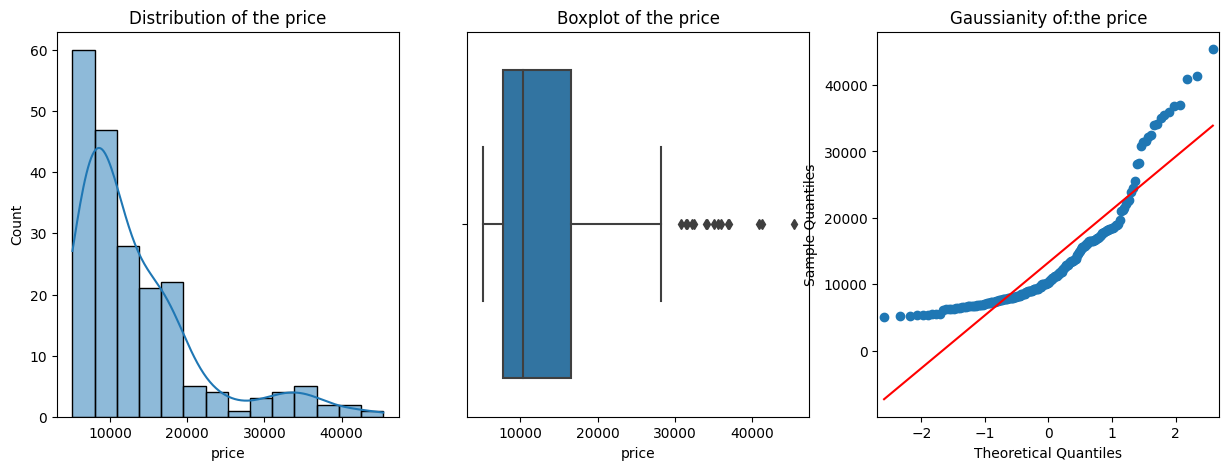

In [37]:
variable = 'price'
y = cars[f"{variable}"]

fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].set_title(f"Distribution of the {variable}")
sns.histplot(data = cars, x = f"{variable}", kde=True, ax = ax[0])

ax[1].set_title(f"Boxplot of the {variable}")
sns.boxplot(data = cars, x = f"{variable}", ax=ax[1])

ax[2].set_title(f"Gaussianity of:the {variable}")
qqplot(cars[f"{variable}"],line='s',ax=ax[2]);

In [38]:
numeric_columns = cars.select_dtypes(include=['number'])
numeric_columns.skew()

symboling           0.211072
wheelbase           1.050214
carlength           0.155954
carwidth            0.904003
carheight           0.063123
curbweight          0.681398
cylindernumber      2.817459
enginesize          1.947655
boreratio           0.020156
stroke             -0.689705
compressionratio    2.610862
horsepower          1.405310
peakrpm             0.075159
citympg             0.663704
highwaympg          0.539997
price               1.777678
dtype: float64

## (2) Preprocessing the features with a Pipeline

In [39]:
X = cars.drop(columns = ["price", "CarName"])

In [40]:
# PIPELINE AND COLUMNTRANSFORMER
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn import set_config; set_config(display="diagram")

# IMPUTERS
from sklearn.impute import SimpleImputer

# SCALERS
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

# ENCODER
from sklearn.preprocessing import OneHotEncoder

### (2.1) Numerical Pipeline

In [41]:
X.dtypes


symboling             int64
fueltype             object
aspiration           object
doornumber           object
carbody              object
drivewheel           object
enginelocation       object
wheelbase           float64
carlength           float64
carwidth            float64
carheight           float64
curbweight            int64
enginetype           object
cylindernumber        int64
enginesize            int64
fuelsystem           object
boreratio           float64
stroke              float64
compressionratio    float64
horsepower            int64
peakrpm               int64
citympg               int64
highwaympg            int64
dtype: object

In [42]:
X.head()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
0,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9.0,111,5000,21,27
1,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9.0,111,5000,21,27
2,1,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,6,152,mpfi,2.68,3.47,9.0,154,5000,19,26
3,2,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,4,109,mpfi,3.19,3.40,10.0,102,5500,24,30
4,2,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,5,136,mpfi,3.19,3.40,8.0,115,5500,18,22


In [43]:
X_num = X.select_dtypes(exclude = ['object'])
X_num.head()

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
0,3,88.6,168.8,64.1,48.8,2548,4,130,3.47,2.68,9.0,111,5000,21,27
1,3,88.6,168.8,64.1,48.8,2548,4,130,3.47,2.68,9.0,111,5000,21,27
2,1,94.5,171.2,65.5,52.4,2823,6,152,2.68,3.47,9.0,154,5000,19,26
3,2,99.8,176.6,66.2,54.3,2337,4,109,3.19,3.40,10.0,102,5500,24,30
4,2,99.4,176.6,66.4,54.3,2824,5,136,3.19,3.40,8.0,115,5500,18,22


In [44]:
num_transformer_simplified = make_pipeline(
                    SimpleImputer(strategy = "median"),
                    RobustScaler()
                )

num_transformer_simplified

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('robustscaler', RobustScaler())])

In [45]:
pd.DataFrame(num_transformer_simplified.fit_transform(X_num), columns=X_num.columns).head()

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
0,1.0,-1.063291,-0.261905,-0.500000,-1.514286,0.169620,0.0,0.227273,0.372093,-2.033333,0.00,0.347826,-0.285714,-0.272727,-0.333333
1,1.0,-1.063291,-0.261905,-0.500000,-1.514286,0.169620,0.0,0.227273,0.372093,-2.033333,0.00,0.347826,-0.285714,-0.272727,-0.333333
2,0.0,-0.316456,-0.119048,0.000000,-0.485714,0.517722,2.0,0.727273,-1.465116,0.600000,0.00,1.282609,-0.285714,-0.454545,-0.444444
3,0.5,0.354430,0.202381,0.250000,0.057143,-0.097468,0.0,-0.250000,-0.279070,0.366667,1.25,0.152174,0.428571,0.000000,0.000000
4,0.5,0.303797,0.202381,0.321429,0.057143,0.518987,1.0,0.363636,-0.279070,0.366667,-1.25,0.434783,0.428571,-0.545455,-0.888889


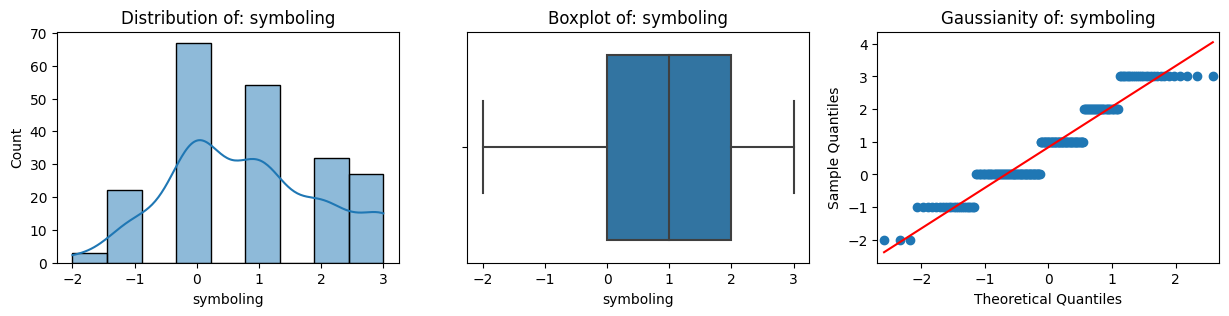

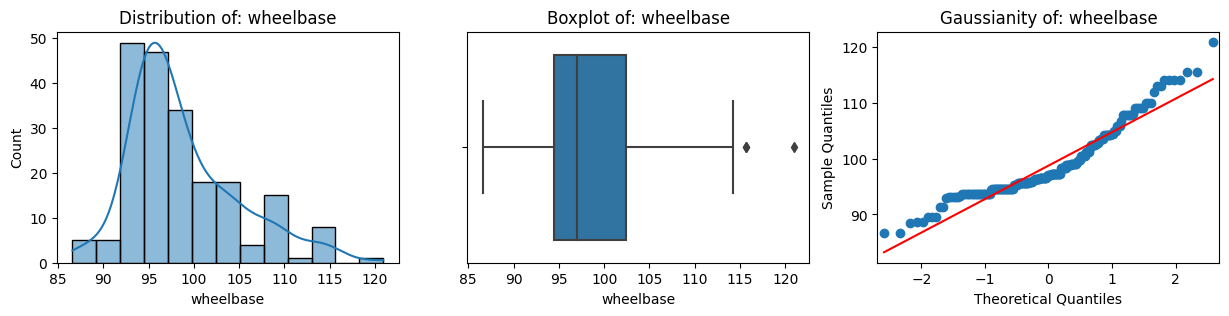

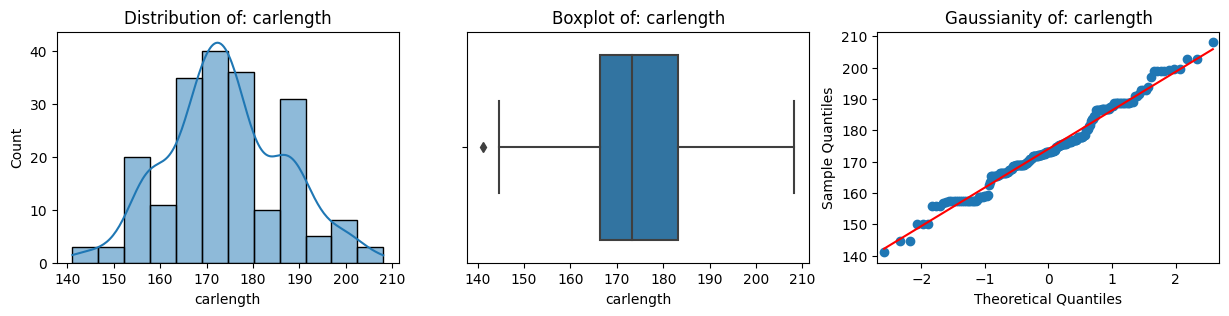

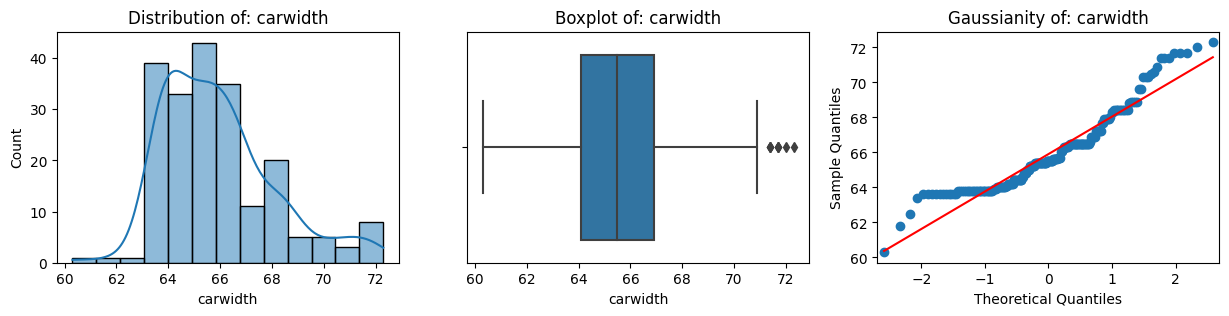

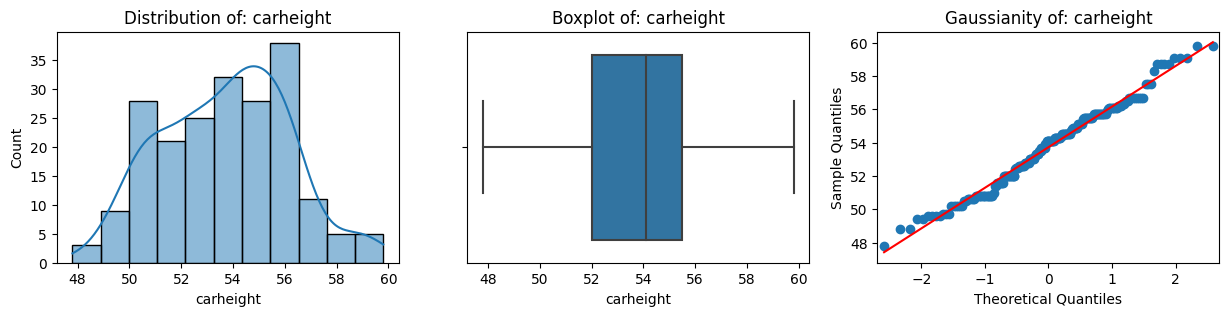

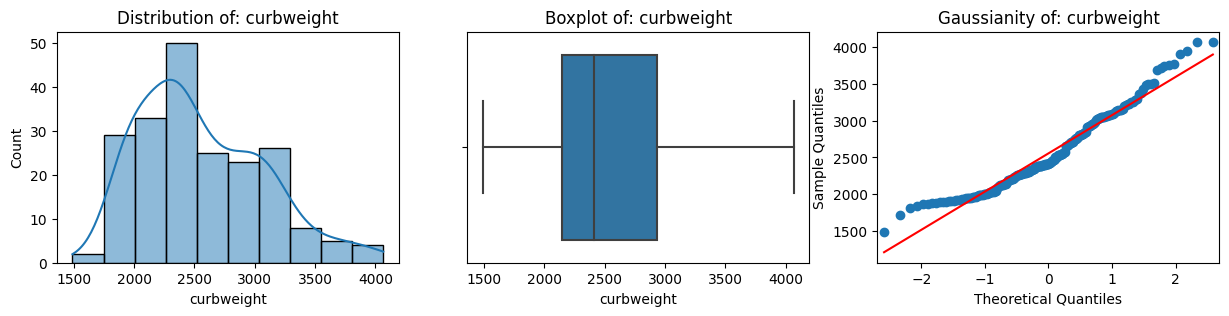

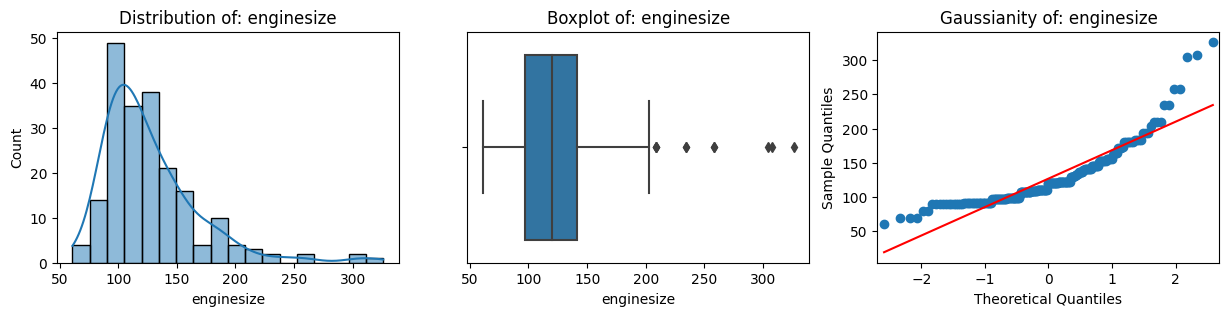

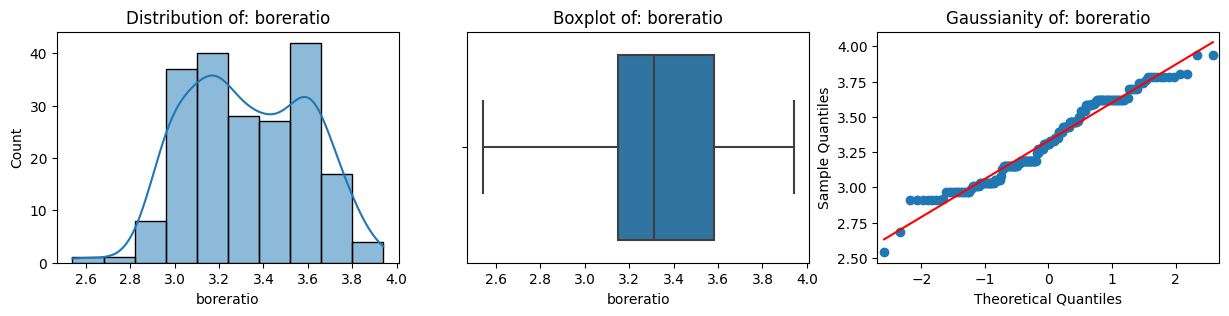

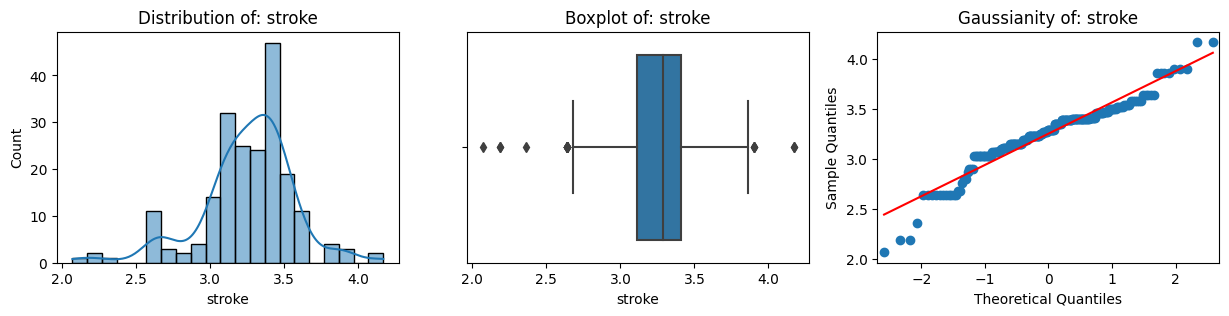

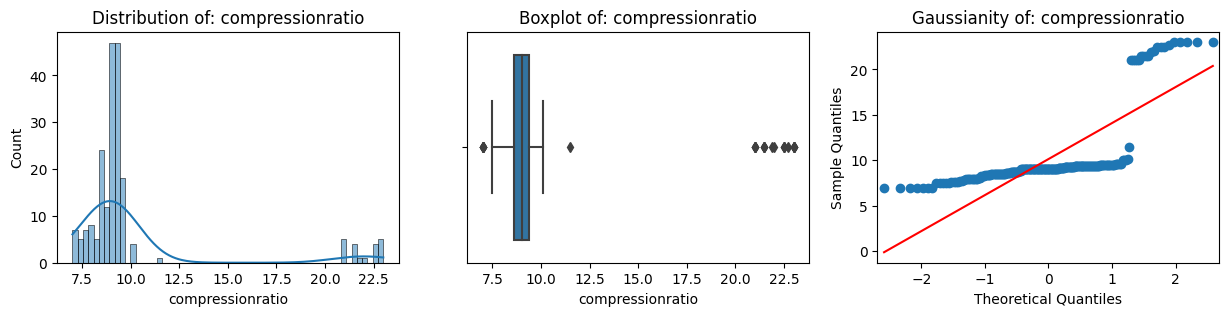

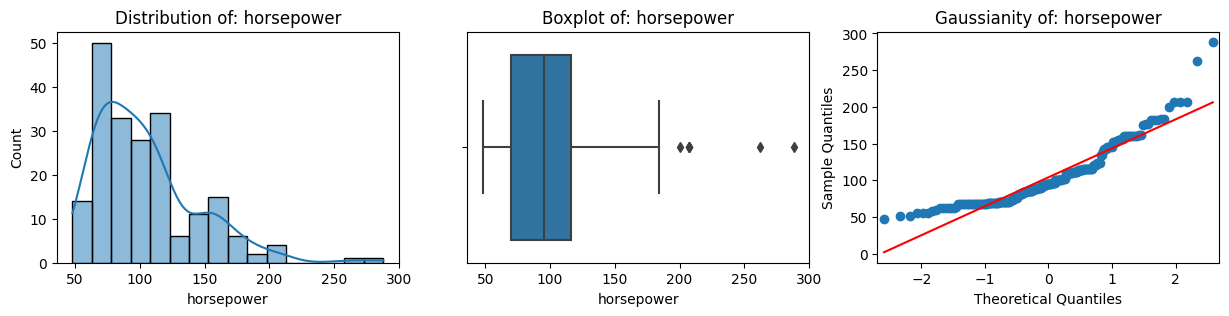

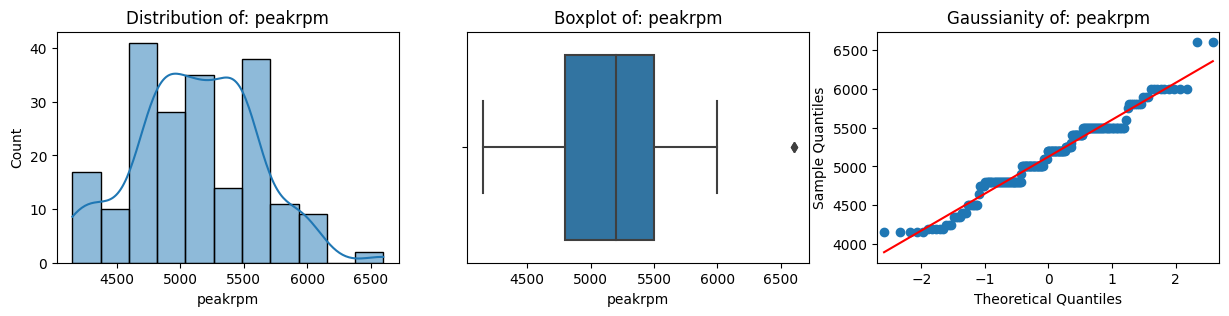

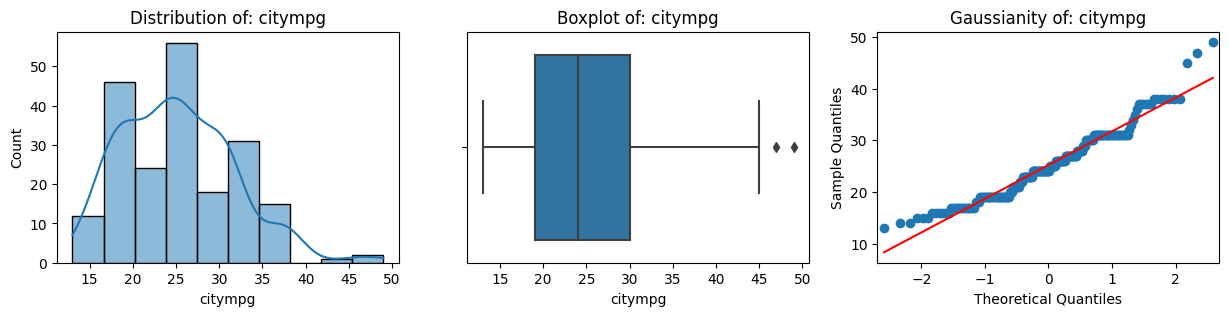

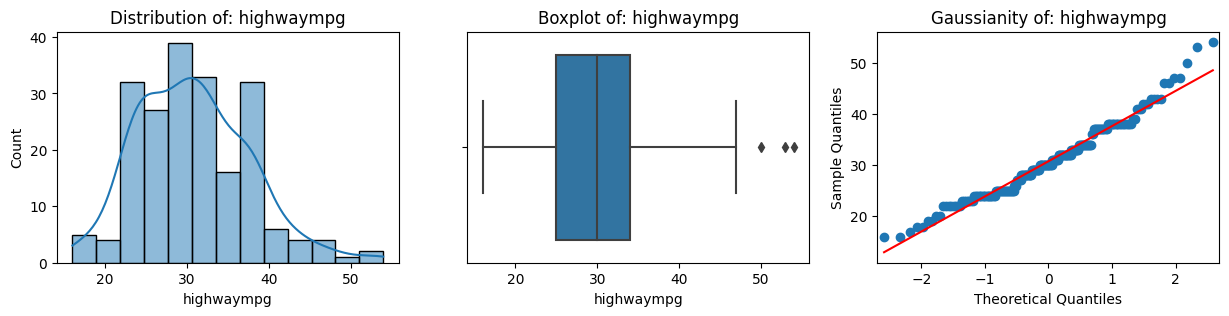

In [22]:
for numerical_feature in X_num.columns:

    # Creating three subplots per numerical_feature
    fig, ax =plt.subplots(1,3,figsize=(15,3))

    # Histogram to get an overview of the distribution of each numerical_feature
    ax[0].set_title(f"Distribution of: {numerical_feature}")
    sns.histplot(data = X_num, x = numerical_feature, kde=True, ax = ax[0])

    # Boxplot to detect outliers
    ax[1].set_title(f"Boxplot of: {numerical_feature}")
    sns.boxplot(data = X_num, x = numerical_feature, ax=ax[1])

    # Analyzing whether a feature is normally distributed or not
    ax[2].set_title(f"Gaussianity of: {numerical_feature}")
    qqplot(X_num[numerical_feature],line='s',ax=ax[2]);

In [46]:
features_robust = ["cylindernumber", "enginesize", "stroke", "compressionratio", "horsepower"]
features_standard = ["symboling", "wheelbase", "carlength", "carwidth", "carheight",\
                          "curbweight", "boreratio", "highwaympg"]
features_minmax = ["peakrpm", "citympg"]
features_already_scaled = []

In [47]:
X_num.shape


(205, 15)

In [48]:
# Checking what we didn't forget any numerical feature
X_num.shape[-1] == len(features_robust + features_standard + features_minmax + features_already_scaled)

True

**Customizing Simple Imputer Class** -  SimpleImputer does not have get_feature_names_out, so we need to add it manually. This should be fixed in Scikit-Learn 1.0.1:


In [49]:
class CustomSimpleImputer(SimpleImputer):
    def fit(self, X, *args, **kwargs):
        self.columns = X.columns
        return super().fit(X, *args, **kwargs)

    def transform(self, *args, **kwargs):
        return pd.DataFrame(super().transform(*args, **kwargs), columns=self.columns)

    def fit_transform(self, *args, **kwargs):
        return pd.DataFrame(super().fit_transform(*args, **kwargs), columns=self.columns)

imputer_with_name = CustomSimpleImputer(strategy='median')

pd.DataFrame(imputer_with_name.fit_transform(X_num)).head()

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
0,3.0,88.6,168.8,64.1,48.8,2548.0,4.0,130.0,3.47,2.68,9.0,111.0,5000.0,21.0,27.0
1,3.0,88.6,168.8,64.1,48.8,2548.0,4.0,130.0,3.47,2.68,9.0,111.0,5000.0,21.0,27.0
2,1.0,94.5,171.2,65.5,52.4,2823.0,6.0,152.0,2.68,3.47,9.0,154.0,5000.0,19.0,26.0
3,2.0,99.8,176.6,66.2,54.3,2337.0,4.0,109.0,3.19,3.40,10.0,102.0,5500.0,24.0,30.0
4,2.0,99.4,176.6,66.4,54.3,2824.0,5.0,136.0,3.19,3.40,8.0,115.0,5500.0,18.0,22.0


In [50]:
num_transformer = make_pipeline(
                    CustomSimpleImputer(strategy='median'),
                    ColumnTransformer(
                                [
                                    ("robust_scaler", RobustScaler(), features_robust),
                                    ("standard_scaler", StandardScaler(), features_standard),
                                    ("minmax_scaler", MinMaxScaler(), features_minmax)
                                ])
                )

num_transformer.fit(X_num)
num_transformer.transform(X_num)

array([[ 0.        ,  0.22727273, -2.03333333, ..., -0.54605874,
         0.34693878,  0.22222222],
       [ 0.        ,  0.22727273, -2.03333333, ..., -0.54605874,
         0.34693878,  0.22222222],
       [ 2.        ,  0.72727273,  0.6       , ..., -0.69162706,
         0.34693878,  0.16666667],
       ...,
       [ 2.        ,  1.20454545, -1.4       , ..., -1.12833203,
         0.55102041,  0.13888889],
       [ 2.        ,  0.56818182,  0.36666667, ..., -0.54605874,
         0.26530612,  0.36111111],
       [ 0.        ,  0.47727273, -0.46666667, ..., -0.83719538,
         0.51020408,  0.16666667]])

In [51]:
# -------------------------------------- #
#   CUSTOMIZED COLUMN TRANSFORMER       #
# -------------------------------------- #
# Nice class to keep the columns'names before fitting a model

class CustomColumnTransformer(ColumnTransformer):

    def fit(self, *args, **kwargs):
        return super().fit(*args, **kwargs)

    def transform(self, X, *args, **kwargs):
        return pd.DataFrame(super().transform(X, *args, **kwargs), columns=self.get_feature_names_out())

    def fit_transform(self, X, *args, **kwargs):
        return pd.DataFrame(super().fit_transform(X, *args, **kwargs), columns=self.get_feature_names_out())

In [52]:
num_transformer = make_pipeline(
                    CustomSimpleImputer(strategy = "median"),
                    CustomColumnTransformer(
                                [
                                    ("robust_scaler", RobustScaler(), features_robust),
                                    ("standard_scaler", StandardScaler(), features_standard),
                                    ("minmax_scaler", MinMaxScaler(), features_minmax)
                                ])
                )

num_transformer.fit(X_num)
num_transformer.transform(X_num)
num_transformer.fit_transform(X_num)

,robust_scaler__cylindernumber,robust_scaler__enginesize,robust_scaler__stroke,robust_scaler__compressionratio,robust_scaler__horsepower,standard_scaler__symboling,standard_scaler__wheelbase,standard_scaler__carlength,standard_scaler__carwidth,standard_scaler__carheight,standard_scaler__curbweight,standard_scaler__boreratio,standard_scaler__highwaympg,minmax_scaler__peakrpm,minmax_scaler__citympg
0,0.0,0.227273,-2.033333,0.000,0.347826,1.743470,-1.690772,-0.426521,-0.844782,-2.020417,-0.014566,0.519071,-0.546059,0.346939,0.222222
1,0.0,0.227273,-2.033333,0.000,0.347826,1.743470,-1.690772,-0.426521,-0.844782,-2.020417,-0.014566,0.519071,-0.546059,0.346939,0.222222
2,2.0,0.727273,0.600000,0.000,1.282609,0.133509,-0.708596,-0.231513,-0.190566,-0.543527,0.514882,-2.404880,-0.691627,0.346939,0.166667
3,0.0,-0.250000,0.366667,1.250,0.152174,0.938490,0.173698,0.207256,0.136542,0.235942,-0.420797,-0.517266,-0.109354,0.551020,0.305556
4,1.0,0.363636,0.366667,-1.250,0.434783,0.938490,0.107110,0.207256,0.230001,0.235942,0.516807,-0.517266,-1.273900,0.551020,0.138889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,0.0,0.477273,-0.466667,0.625,0.413043,-1.476452,1.721873,1.198549,1.398245,0.728239,0.763241,1.666445,-0.400490,0.510204,0.277778
201,0.0,0.477273,-0.466667,-0.375,1.413043,-1.476452,1.721873,1.198549,1.351515,0.728239,0.949992,1.666445,-0.837195,0.469388,0.166667
202,2.0,1.204545,-1.400000,-0.250,0.847826,-1.476452,1.721873,1.198549,1.398245,0.728239,0.878757,0.926204,-1.128332,0.551020,0.138889
203,2.0,0.568182,0.366667,17.500,0.239130,-1.476452,1.721873,1.198549,1.398245,0.728239,1.273437,-1.183483,-0.546059,0.265306,0.361111


### (2.2) Categorical Pipeline

In [53]:
X_cat = X.select_dtypes(include=['object'])
X_cat.head()

,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,fuelsystem
0,gas,std,two,convertible,rwd,front,dohc,mpfi
1,gas,std,two,convertible,rwd,front,dohc,mpfi
2,gas,std,two,hatchback,rwd,front,ohcv,mpfi
3,gas,std,four,sedan,fwd,front,ohc,mpfi
4,gas,std,four,sedan,4wd,front,ohc,mpfi


In [54]:
cat_features = list(X_cat.columns)
cat_features

['fueltype',
 'aspiration',
 'doornumber',
 'carbody',
 'drivewheel',
 'enginelocation',
 'enginetype',
 'fuelsystem']

In [55]:
unique_occurences = {cat_feature:
                                 len(X_cat[cat_feature].value_counts())
                                 for cat_feature in X_cat.columns}

unique_occurences = pd.DataFrame.from_dict(unique_occurences,
                                                       orient = "index",
                                                       columns = ["unique_occurences"])

unique_occurences = unique_occurences.sort_values(by = "unique_occurences",
                                                  ascending = False)

In [56]:
print(unique_occurences)

                unique_occurences
fuelsystem                      8
enginetype                      7
carbody                         5
drivewheel                      3
fueltype                        2
aspiration                      2
doornumber                      2
enginelocation                  2


In [58]:
binary_cat = list(unique_occurences[unique_occurences.unique_occurences <= 2].index)
binary_cat

['fueltype', 'aspiration', 'doornumber', 'enginelocation']

In [57]:
multiple_cat = list(unique_occurences[unique_occurences.unique_occurences > 2].index)
multiple_cat

['fuelsystem', 'enginetype', 'carbody', 'drivewheel']

In [59]:
columns_generated_by_multiple_ohe = unique_occurences.loc[multiple_cat].sum()[0]
columns_generated_by_binary_ohe = len(binary_cat)
columns_ohe = columns_generated_by_multiple_ohe + columns_generated_by_binary_ohe



print(f"If we are to One-Hot-Encode all the categorical columns of this cars' dataset, we will generate {columns_generated_by_multiple_ohe} + {columns_generated_by_binary_ohe} = {columns_ohe} columns")

If we are to One-Hot-Encode all the categorical columns of this cars' dataset, we will generate 23 + 4 = 27 columns


In [60]:
cat_transformer = make_pipeline(
                    SimpleImputer(strategy = "most_frequent"),
                    OneHotEncoder(sparse_output = False, handle_unknown = "ignore", drop='if_binary')
                )

cat_transformer

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(drop='if_binary', handle_unknown='ignore',
                               sparse_output=False))])

In [61]:
X_cat_encoded = pd.DataFrame(cat_transformer.fit_transform(X_cat))
X_cat_encoded

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
201,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
202,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
203,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [62]:
# cutstom OHE that passes column names
from sklearn.preprocessing import OneHotEncoder

class CustomOHE(OneHotEncoder):
    def fit(self, *args, **kwargs):
        return super().fit(*args, **kwargs)

    def transform(self,*args, **kwargs):
        return pd.DataFrame(super().transform(*args, **kwargs), columns=self.get_feature_names_out())

    def fit_transform(self,*args, **kwargs):
        return pd.DataFrame(super().fit_transform(*args, **kwargs), columns=self.get_feature_names_out())

cat_transformer = make_pipeline(
                    CustomSimpleImputer(strategy = "most_frequent"),
                    CustomOHE(sparse_output = False, handle_unknown = "ignore", drop='if_binary')
                )
X_cat_encoded = pd.DataFrame(cat_transformer.fit_transform(X_cat))
X_cat_encoded.shape

(205, 27)

### (2.3) Full Preprocessor

In [65]:
preprocessor = make_pipeline(
                CustomColumnTransformer([
                    ("num_transformer", num_transformer, make_column_selector(dtype_include = ["float64","int64"])),
                    ("cat_transformer", cat_transformer, make_column_selector(dtype_include = "object"))
                    ])
                )

preprocessor

Pipeline(steps=[('customcolumntransformer',
                 CustomColumnTransformer(transformers=[('num_transformer',
                                                        Pipeline(steps=[('customsimpleimputer',
                                                                         CustomSimpleImputer(strategy='median')),
                                                                        ('customcolumntransformer',
                                                                         CustomColumnTransformer(transformers=[('robust_scaler',
                                                                                                                RobustScaler(),
                                                                                                                ['cylindernumber',
                                                                                                                 'enginesize',
                                                                                                                 'stroke',
                                                                                                                 'compressionratio',
                                                                                                                 'horsepower']),...
                                                        <sklearn.compose._column_transformer.make_column_selector object at 0x7f8200b599c0>),
                                                       ('cat_transformer',
                                                        Pipeline(steps=[('customsimpleimputer',
                                                                         CustomSimpleImputer(strategy='most_frequent')),
                                                                        ('customohe',
                                                                         CustomOHE(drop='if_binary',
                                                                                   handle_unknown='ignore',
                                                                                   sparse_output=False))]),
                                                        <sklearn.compose._column_transformer.make_column_selector object at 0x7f8201cd0340>)]))])

In [66]:
fully_preprocessed_dataset = pd.DataFrame(preprocessor.fit_transform(X))
fully_preprocessed_dataset

,num_transformer__robust_scaler__cylindernumber,num_transformer__robust_scaler__enginesize,num_transformer__robust_scaler__stroke,num_transformer__robust_scaler__compressionratio,num_transformer__robust_scaler__horsepower,num_transformer__standard_scaler__symboling,num_transformer__standard_scaler__wheelbase,num_transformer__standard_scaler__carlength,num_transformer__standard_scaler__carwidth,num_transformer__standard_scaler__carheight,num_transformer__standard_scaler__curbweight,num_transformer__standard_scaler__boreratio,num_transformer__standard_scaler__highwaympg,num_transformer__minmax_scaler__peakrpm,num_transformer__minmax_scaler__citympg,cat_transformer__fueltype_gas,cat_transformer__aspiration_turbo,cat_transformer__doornumber_two,cat_transformer__carbody_convertible,cat_transformer__carbody_hardtop,cat_transformer__carbody_hatchback,cat_transformer__carbody_sedan,cat_transformer__carbody_wagon,cat_transformer__drivewheel_4wd,cat_transformer__drivewheel_fwd,cat_transformer__drivewheel_rwd,cat_transformer__enginelocation_rear,cat_transformer__enginetype_dohc,cat_transformer__enginetype_dohcv,cat_transformer__enginetype_l,cat_transformer__enginetype_ohc,cat_transformer__enginetype_ohcf,cat_transformer__enginetype_ohcv,cat_transformer__enginetype_rotor,cat_transformer__fuelsystem_1bbl,cat_transformer__fuelsystem_2bbl,cat_transformer__fuelsystem_4bbl,cat_transformer__fuelsystem_idi,cat_transformer__fuelsystem_mfi,cat_transformer__fuelsystem_mpfi,cat_transformer__fuelsystem_spdi,cat_transformer__fuelsystem_spfi
0,0.0,0.227273,-2.033333,0.000,0.347826,1.743470,-1.690772,-0.426521,-0.844782,-2.020417,-0.014566,0.519071,-0.546059,0.346939,0.222222,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.227273,-2.033333,0.000,0.347826,1.743470,-1.690772,-0.426521,-0.844782,-2.020417,-0.014566,0.519071,-0.546059,0.346939,0.222222,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2.0,0.727273,0.600000,0.000,1.282609,0.133509,-0.708596,-0.231513,-0.190566,-0.543527,0.514882,-2.404880,-0.691627,0.346939,0.166667,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,-0.250000,0.366667,1.250,0.152174,0.938490,0.173698,0.207256,0.136542,0.235942,-0.420797,-0.517266,-0.109354,0.551020,0.305556,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.363636,0.366667,-1.250,0.434783,0.938490,0.107110,0.207256,0.230001,0.235942,0.516807,-0.517266,-1.273900,0.551020,0.138889,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,0.0,0.477273,-0.466667,0.625,0.413043,-1.476452,1.721873,1.198549,1.398245,0.728239,0.763241,1.666445,-0.400490,0.510204,0.277778,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
201,0.0,0.477273,-0.466667,-0.375,1.413043,-1.476452,1.721873,1.198549,1.351515,0.728239,0.949992,1.666445,-0.837195,0.469388,0.166667,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
202,2.0,1.204545,-1.400000,-0.250,0.847826,-1.476452,1.721873,1.198549,1.398245,0.728239,0.878757,0.926204,-1.128332,0.551020,0.138889,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
203,2.0,0.568182,0.366667,17.500,0.239130,-1.476452,1.721873,1.198549,1.398245,0.728239,1.273437,-1.183483,-0.546059,0.265306,0.361111,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## (3) Full pipeline with a Regression Model

A function that will create a Pipeline with the preprocessor and a regression model 

In [72]:
def cars_regression_models(regression_model):
    piped_regressor = make_pipeline(preprocessor, regression_model)
    return piped_regressor

In [67]:
# LINEAR MODELS
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor

# NEIGHBORS
from sklearn.neighbors import KNeighborsRegressor

# SVM
from sklearn.svm import SVR

# TREES AND ENSEMBLE METHODS
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

In [68]:
models = [LinearRegression(),
          Ridge(),
          Lasso(),
          ElasticNet(),
          SGDRegressor(),
          KNeighborsRegressor(),
          SVR(kernel = "linear"),
          SVR(kernel = "poly", degree = 2),
          SVR(kernel = "poly", degree = 3),
          SVR(kernel = "rbf"),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          AdaBoostRegressor(),
          GradientBoostingRegressor()
]

In [69]:
models_names = ["linear_regression",
                "ridge",
                "lasso",
                "elastic_net",
                "sgd_regressor",
                "kneighbors_regressor",
                "SVR_linear",
                "SVR_poly_two",
                "SVR_poly_three",
                "SVR_rbf",
                "decision_tree_regressor",
                "random_forest_regressor",
                "ada_boost_regressor",
                "gradient_boosting_regressor"
]

In [70]:
from sklearn.model_selection import train_test_split

In [73]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X, y)
different_test_scores = []

for model_name, model in zip(models_names, models):

    temp_piped_regressor = cars_regression_models(model)
    temp_piped_regressor.fit(X_train, y_train)
    different_test_scores.append(temp_piped_regressor.score(X_test, y_test))


comparing_regression_models_cars = pd.DataFrame(list(zip(models_names, different_test_scores)),
                                                columns =['model_name', 'test_score'])

round(comparing_regression_models_cars.sort_values(by = "test_score", ascending = False),2)

CPU times: user 5.88 s, sys: 685 ms, total: 6.56 s
Wall time: 5.94 s


,model_name,test_score
13,gradient_boosting_regressor,0.91
11,random_forest_regressor,0.89
12,ada_boost_regressor,0.89
10,decision_tree_regressor,0.84
1,ridge,0.79
2,lasso,0.79
0,linear_regression,0.79
4,sgd_regressor,0.78
3,elastic_net,0.69
5,kneighbors_regressor,0.63
